
# Net Worth by Date
## Load the various utility libraries to setup the notebook

In [1]:

from datetime import datetime
from pandas import DataFrame
from scipy.optimize import fsolve, curve_fit
import locale, re
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import matplotlib.ticker as mticker
%matplotlib inline

# Use the following only if you are on a high definition device
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

# Load notebook utilities and reuglify print
import sys
sys.path.insert(1, osp.abspath('../py'))
from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)
%pprint

Pretty printing has been turned OFF



## Simple functions

In [2]:

# Define the exponential decay function
exp_decay = lambda x, y0, yp, K: y0 + (yp - y0) * (1 - np.exp(-K * (x-X0)))

# Define a function to evaluate the fitted exponential decay curve at any lap number
exponential_decay_fit = lambda x: y0 + (yp - y0) * (1 - np.exp(-K * (x-X0)))

# Define the function to find the root of (exponential_decay_fit - net_worth)
fsolve_equation = lambda record_date, net_worth: exponential_decay_fit(record_date) - net_worth

In [3]:

def get_r_squared_string(xdata, ydata, prefix_str=''):
    
    # Get r squared value
    inf_nan_mask = nu.get_inf_nan_mask(xdata.tolist(), ydata.tolist())
    from scipy.stats import pearsonr
    pearsonr_tuple = pearsonr(xdata[inf_nan_mask], ydata[inf_nan_mask])
    pearson_r = pearsonr_tuple[0]
    pearsonr_statement = str('%.2f' % pearson_r)
    coefficient_of_determination_statement = str('%.2f' % pearson_r**2)
    p_value = pearsonr_tuple[1]
    
    if p_value < 0.0001: pvalue_statement = '<0.0001'
    else: pvalue_statement = '=' + str('%.4f' % p_value)
    
    s_str = prefix_str + f': $r^2=' + coefficient_of_determination_statement + ',\ p' + pvalue_statement + '$'
    
    return s_str


## Clean and preprocess the net worth dataset

In [4]:

file_path = osp.join(nu.data_folder, 'txt', 'Net_Worth_by_Date.txt')
with open(file_path, 'r', encoding='utf-8') as f: export_str = f.read()

In [5]:

lines_list = export_str.split('\n')[1:-1]
currency_regex = re.compile('[^0-9.-]+')
rows_list = []
for date_str, worth_str in zip(lines_list[::2], lines_list[1::2]):
    row_dict = {}
    datetime_obj = datetime.strptime(date_str, '- %A, %B %d, %Y')
    row_dict['record_date'] = datetime_obj
    net_worth = float(currency_regex.sub('', worth_str))
    row_dict['net_worth'] = net_worth
    rows_list.append(row_dict)
net_worth_df = DataFrame(rows_list).set_index('record_date')


## Visualize the interesting aspects

In [6]:

# Get record dates and net worth values
record_dates = np.array([d.timestamp() for d in net_worth_df.index])
X0 = record_dates[0]  # Initial value of record_dates
net_worths = net_worth_df.net_worth.values

# Fit a line to the data points
coefficients = np.polyfit(record_dates, net_worths, 1)

# Create a line using the fitted coefficients
line_fit = np.polyval(coefficients, record_dates)

# Create a smoother x range for plotting the fitted curve
smoothx = np.linspace(X0, record_dates[-1], 20)

In [7]:

# Initial guess for the parameters of the exponential decay curve
# The parameters of the exponential decay function have the following meanings:
# guess_y0: The y-intercept of the exponential decay curve.
# guess_yp: The initial value of the exponential decay curve.
# guess_K: The decay rate of the exponential decay curve.
guess_y0, guess_yp, guess_K = -53041.19187840272, -27367.797567937872, 0.0000000486

# Fit the exponential decay function to the data using curve fitting
params, cov = curve_fit(exp_decay, record_dates, net_worths, p0=[guess_y0, guess_yp, guess_K])

# Extract the parameters of the fitted exponential decay curve
y0, yp, K = params

# Print the fitted parameters for reintroduction as guesses
print(f'guess_y0, guess_yp, guess_K = {y0}, {yp}, {K:,.10f}\n')

# Print the fitted parameters for visualization
locale.setlocale(locale.LC_ALL, 'en_US')
print(f'y0 = {locale.currency(y0, grouping=True)}\nyp = {locale.currency(yp, grouping=True)}\nK = {K:,.10f}\n')

guess_y0, guess_yp, guess_K = -53041.1918352098, -27367.79755222626, 0.0000000486

y0 = ($53,041.19)
yp = ($27,367.80)
K = 0.0000000486



Record Date where Linear Fit equals zero Net Worth: Sunday, January 09, 2028
Record Date where Exponential Decay Fit equals zero Net Worth: Wednesday, August 07, 2041


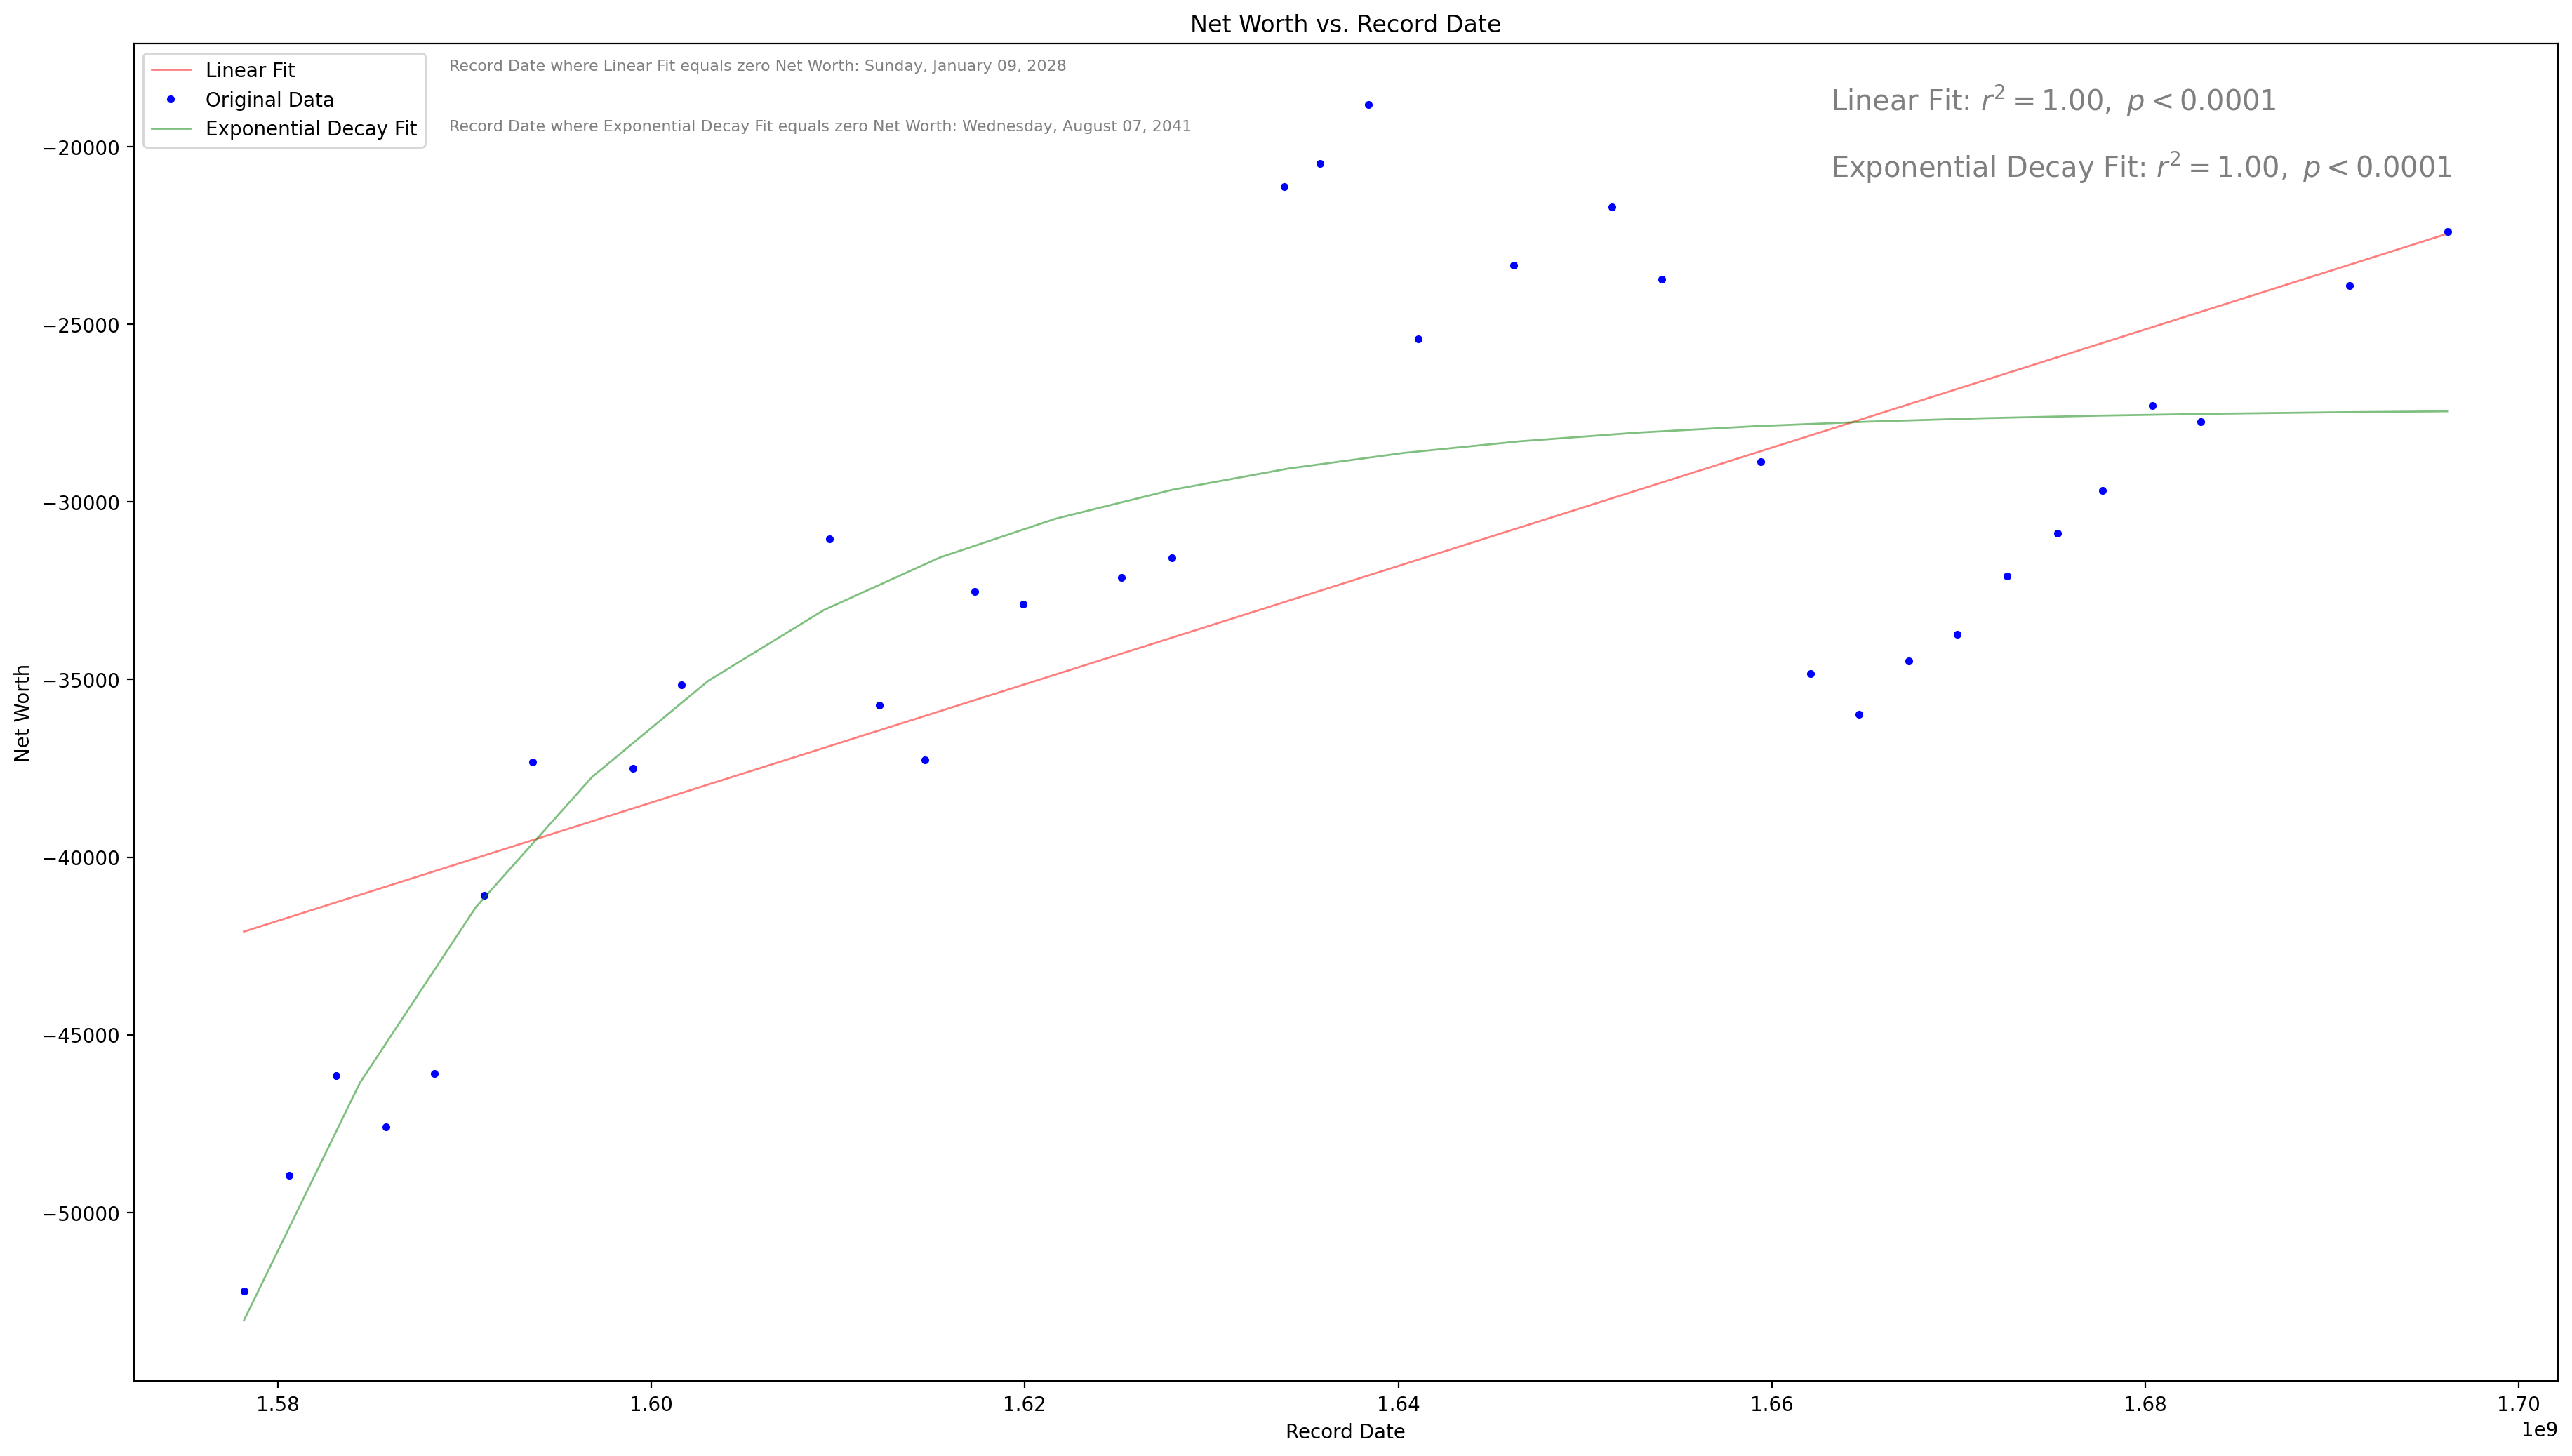

In [9]:

# Create the figure and subplot
fig, ax = plt.subplots(figsize=(18, 18/nu.twitter_aspect_ratio))
fig.tight_layout()

# Plot the fitted line
ax.plot(record_dates, line_fit, color='red', linewidth=1, alpha=0.5, label='Linear Fit')

# Plot the original data points and the best-fit curve
ax.plot(record_dates, net_worths, 'b.', label='Original Data')  # Plot data points
ax.plot(smoothx, exponential_decay_fit(smoothx), 'g-', label='Exponential Decay Fit', linewidth=1, alpha=0.5)  # Plot the fitted curve

# Set labels, legend, and title
ax.set_xlabel('Record Date')
ax.set_ylabel('Net Worth')
ax.set_title('Net Worth vs. Record Date')

# Show legend
ax.legend(loc='upper left')

# Annotate the linear fit
s_str = get_r_squared_string(record_dates, line_fit, prefix_str=r'Linear Fit')
text_tuple = ax.text(0.7, 0.95, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Solve the equation for Record Date
record_date = (0 - coefficients[1]) / coefficients[0]
date_str = datetime.fromtimestamp(record_date).strftime('%A, %B %d, %Y')
text_str = f'Record Date where Linear Fit equals zero Net Worth: {date_str}'
print(text_str)
text_tuple = ax.text(0.13, 0.98, text_str, alpha=0.5, transform=ax.transAxes, fontsize=8)

# Annotate the exponential fit
s_str = get_r_squared_string(record_dates, line_fit, prefix_str=r'Exponential Decay Fit')
text_tuple = ax.text(0.7, 0.9, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Solve the equation for record_date
record_date_solution = fsolve(fsolve_equation, x0=X0, args=(0))
date_str = datetime.fromtimestamp(record_date_solution[0]).strftime('%A, %B %d, %Y')
text_str = f'Record Date where Exponential Decay Fit equals zero Net Worth: {date_str}'
print(text_str)
text_tuple = ax.text(
    0.13, 0.935, text_str, alpha=0.5, transform=ax.transAxes, fontsize=8
)

# Show the plot
plt.show()